## Load and Explore Global Streetscapes data

This notebook explores a subset of the [global streetscapes](https://ual.sg/project/global-streetscapes/) dataset saved in parquet format. How to plot and use the data was derived from the [notebooks](https://github.com/ualsg/global-streetscapes/blob/main/notebooks/visualise_dataset.ipynb) provided by the [Urban Analytics Lab (UAL)](https://ual.sg/).

### Load Parquet dataset

In [54]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
import osmnx as ox

# --------------------------------------
import geopandas as gp

# --------------------------------------
import matplotlib.pyplot as plt

# --------------------------------------
from streetscapes.functions import load_city_subset

In [55]:
df_city = load_city_subset("Amsterdam")

Streetscapes | 2024-12-11@15:30:49 | Loading 'Amsterdam.parquet'...


### Subset dataset

First, let's subset to a city of interest, in this case Amsterdam, but this workflow can be used for any city in the dataset. Then, create a geodataframe. 

In [56]:
df_city.head()

,uuid,source,orig_id,lat,lon,datetime_local,year,month,day,hour,...,city_id,city_lat,city_lon,country,iso2,iso3,admin_name,capital,population,continent
1889009,19c6e51e-fe64-4756-895d-7758889dbbd1,Mapillary,793569314897389,52.367188,4.893492,2020-09-20 12:43:12+02:00,2020,9,20,12,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
1889010,580ce8e7-fbdb-45e6-971b-6d5b6523d0ef,Mapillary,500509417737025,52.373929,4.884667,2020-09-21 18:50:13+02:00,2020,9,21,18,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
1889011,db31e5bc-5180-4320-b267-04ba3da0a980,Mapillary,299548784985576,52.366510,4.882237,2016-08-16 09:28:19.737000+02:00,2016,8,16,9,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
1889012,642298a7-563e-4650-b308-5e4371238b84,Mapillary,300520878202732,52.367038,4.890080,2017-03-02 17:26:02+01:00,2017,3,2,17,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
1889013,32eeddbe-c4f0-4ac1-aff0-a0d19d258ae5,Mapillary,416737606538178,52.369855,4.892274,2022-05-03 15:48:18.941000+02:00,2022,5,3,15,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe


In [57]:
city_pts = gp.GeoDataFrame(
    df_city, geometry=gp.points_from_xy(df_city.lon, df_city.lat), crs="EPSG:4326"
)

We can now subset the data further for images that were taken during the day and that have a viewing direction from the side.

In [58]:
city_day = city_pts[city_pts["lighting_condition"] == "day"]
city_side = city_day[city_day["view_direction"] == "side"]

We can take this further and calculate the fraction of pixels of each image that contain a certain object of interest. In this example at least 25% building or wall. 

In [59]:
city_day['building_fraction'] = city_day.apply(lambda x: x['Building']/x['Total'], axis=1)
city_day['wall_fraction'] = city_day.apply(lambda x: x['Wall']/x['Total'], axis=1)
city_walls = city_day[(city_day["wall_fraction"] > 0.15) | (city_day["building_fraction"] > 0.15)]
city_walls.head(5)

,uuid,source,orig_id,lat,lon,datetime_local,year,month,day,hour,...,country,iso2,iso3,admin_name,capital,population,continent,geometry,building_fraction,wall_fraction
1889011,db31e5bc-5180-4320-b267-04ba3da0a980,Mapillary,299548784985576,52.366510,4.882237,2016-08-16 09:28:19.737000+02:00,2016,8,16,9,...,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe,POINT (4.88224 52.36651),0.203051,0.000000
1889012,642298a7-563e-4650-b308-5e4371238b84,Mapillary,300520878202732,52.367038,4.890080,2017-03-02 17:26:02+01:00,2017,3,2,17,...,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe,POINT (4.89008 52.36704),0.413743,0.000000
1889013,32eeddbe-c4f0-4ac1-aff0-a0d19d258ae5,Mapillary,416737606538178,52.369855,4.892274,2022-05-03 15:48:18.941000+02:00,2022,5,3,15,...,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe,POINT (4.89227 52.36985),0.240777,0.003113
1889014,a3e976b7-6d65-473a-b883-e2f7aa87cf88,Mapillary,330594301743171,52.370752,4.886674,2020-09-21 13:57:04+02:00,2020,9,21,13,...,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe,POINT (4.88667 52.37075),0.236397,0.005630
1889018,699a0bc2-d366-41a8-99f0-575ff248293a,Mapillary,1674999216025212,52.366605,4.879410,2020-09-21 13:47:16+02:00,2020,9,21,13,...,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe,POINT (4.87941 52.36661),0.162567,0.025887


### Create plot

Now that we have subset the data, we can create a plot to visualise where these images are. 

In [60]:
# Create bounding box and background for figure
north, south, east, west = (
    city_pts.total_bounds[0],
    city_pts.total_bounds[1],
    city_pts.total_bounds[2],
    city_pts.total_bounds[3],
)
G = ox.graph_from_bbox(
    (north, south, east, west),
    network_type="all",
    simplify=True,
    retain_all=True,
    truncate_by_edge=False,
)
df_G = ox.graph_to_gdfs(G)
df_lines = df_G[1].copy()


<Axes: >

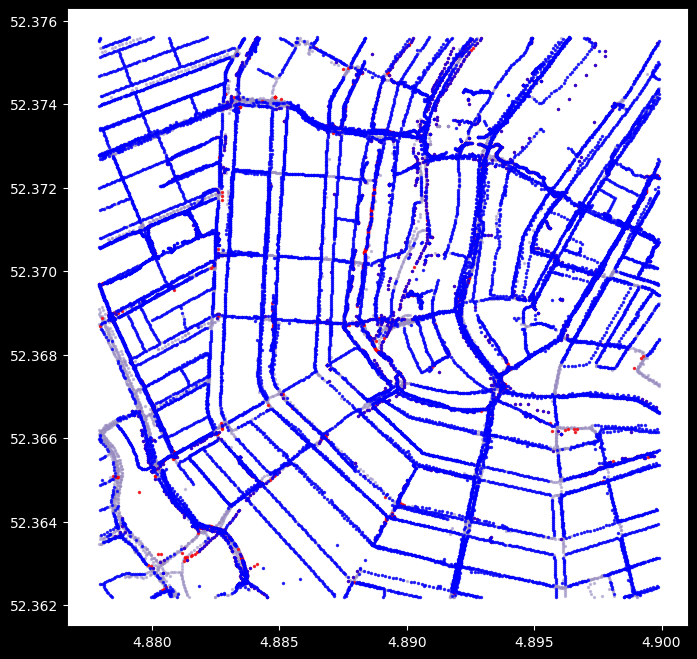

In [61]:
# create figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("#ffffff")

# plot place area on Axis ax
df_lines.plot(ax=ax, color="white", zorder=5)

# plot all points
city_pts.plot(ax=ax, marker="o", color="#998cc0", markersize=2, alpha=0.5, zorder=10)

# plot side view points
city_side.plot(ax=ax, marker="o", color="red", markersize=2, alpha=0.7, zorder=15)

# plot points with walls and buildings
city_walls.plot(ax=ax, marker="o", color="blue", markersize=2, alpha=0.7, zorder=15)